# Introduction to Seaborn

## About the Data
In this notebook, we will be working with 2 datasets:
- Facebook's stock price throughout 2018 (obtained using the [`stock_analysis` package](https://github.com/stefmolin/stock-analysis))
- Earthquake data from September 18, 2018 - October 13, 2018 (obtained from the US Geological Survey (USGS) using the [USGS API](https://earthquake.usgs.gov/fdsnws/event/1/))

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

fb = pd.read_csv(
    'data/fb_stock_prices_2018.csv', index_col='date', parse_dates=True
)
quakes = pd.read_csv('data/earthquakes.csv')

## Categorical data
A [7.5 magnitude earthquake on September 28, 2018 near Palu, Indonesia caused a devastating tsunami afterwards](https://www.livescience.com/63721-tsunami-earthquake-indonesia.html). Let's take a look at some visualizations to understand which magnitude techniques (`magType`) are used in Indonesia, the range of magnitudes there, and how many of the earthquakes are accompanied by a tsunami.

In [2]:
quakes.assign(
    time=lambda x: pd.to_datetime(x.time, unit='ms')
).set_index('time').loc['2018-09-28'].query(
    'parsed_place == "Indonesia" and tsunami and mag == 7.5'
)

,mag,magType,place,tsunami,parsed_place
time,,,,,
2018-09-28 10:02:43.480,7.5,mww,"78km N of Palu, Indonesia",1,Indonesia


### `stripplot()`
The `stripplot()` function helps us visualize categorical data on one axis and numerical data on the other. We also now have the option of coloring our points using a column of our data (with the `hue` parameter). Using a strip plot, we can see points for each earthquake that was measured with a given `magType` and what its magnitude was; however, it isn't too easy to see density of the points due to overlap:

<AxesSubplot:xlabel='magType', ylabel='mag'>

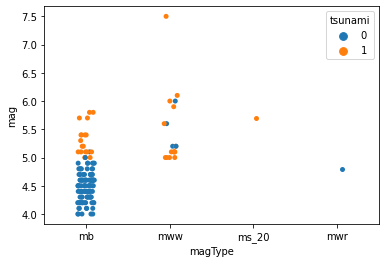

In [3]:
sns.stripplot(
    x='magType',
    y='mag',
    hue='tsunami',
    data=quakes.query('parsed_place == "Indonesia"')
)

### `swarmplot()`
The bee swarm plot helps address this issue by keeping the points from overlapping. Notice how many more points we can see for the blue section of the `mb` column:

<AxesSubplot:xlabel='magType', ylabel='mag'>

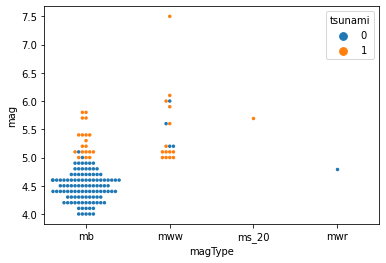

In [4]:
sns.swarmplot(
    x='magType',
    y='mag',
    hue='tsunami',
    data=quakes.query('parsed_place == "Indonesia"'),
    size=3.5 # point size
)

### `boxenplot()`
The `boxenplot()` function creates an enhanced box plot that shows additional quantiles:

Text(0.5, 1.0, 'Comparing earthquake magnitude by magType')

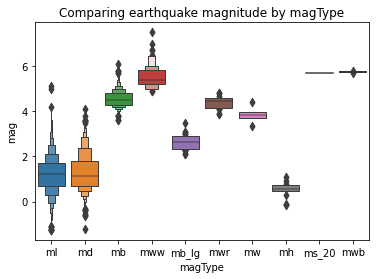

In [5]:
sns.boxenplot(
    x='magType', y='mag', data=quakes[['magType', 'mag']]
)
plt.title('Comparing earthquake magnitude by magType')

*Read more about this plot type in this paper: [Letter-value plots: Boxplots for large data](https://vita.had.co.nz/papers/letter-value-plot.html)*

### `violinplot()`
Violin plots combine box plots and KDEs:

Text(0.5, 1.0, 'Comparing earthquake magnitude by magType')

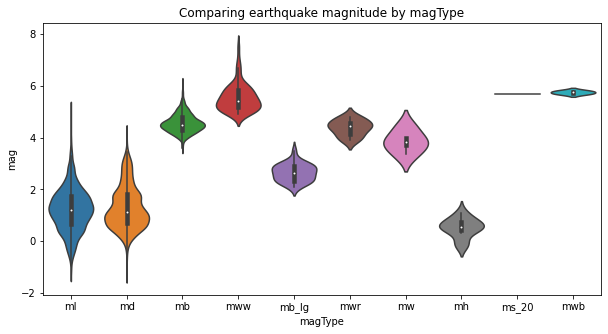

In [6]:
fig, axes = plt.subplots(figsize=(10, 5))
sns.violinplot(
    x='magType', y='mag', data=quakes[['magType', 'mag']],  
    ax=axes, scale='width' # all violins have same width
)
plt.title('Comparing earthquake magnitude by magType')

## Correlations and Heatmaps

### `heatmap()`
Last chapter, we saw how to create a correlation matrix heatmap using `pandas` and `matplotlib` (in the [`2-plotting_with_pandas.ipynb`](../ch_05/2-plotting_with_pandas.ipynb) notebook). An easier way is to use `seaborn`:

<AxesSubplot:>

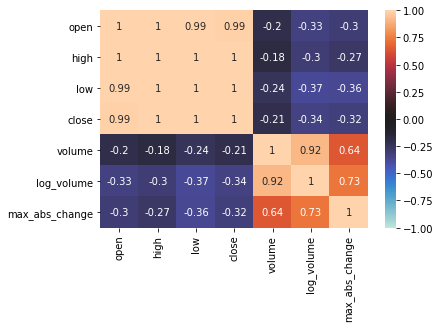

In [7]:
sns.heatmap(
    fb.sort_index().assign(
        log_volume=np.log(fb.volume),
        max_abs_change=fb.high - fb.low
    ).corr(),
    annot=True, center=0, vmin=-1, vmax=1
)

### `pairplot()`
The pair plot is seaborn's answer to the scatter matrix we saw in chapter 5 (`pandas.plotting.scatter_matrix()`) in the [`3-pandas_plotting_module.ipynb`](../ch_05/3-pandas_plotting_module.ipynb) notebook:

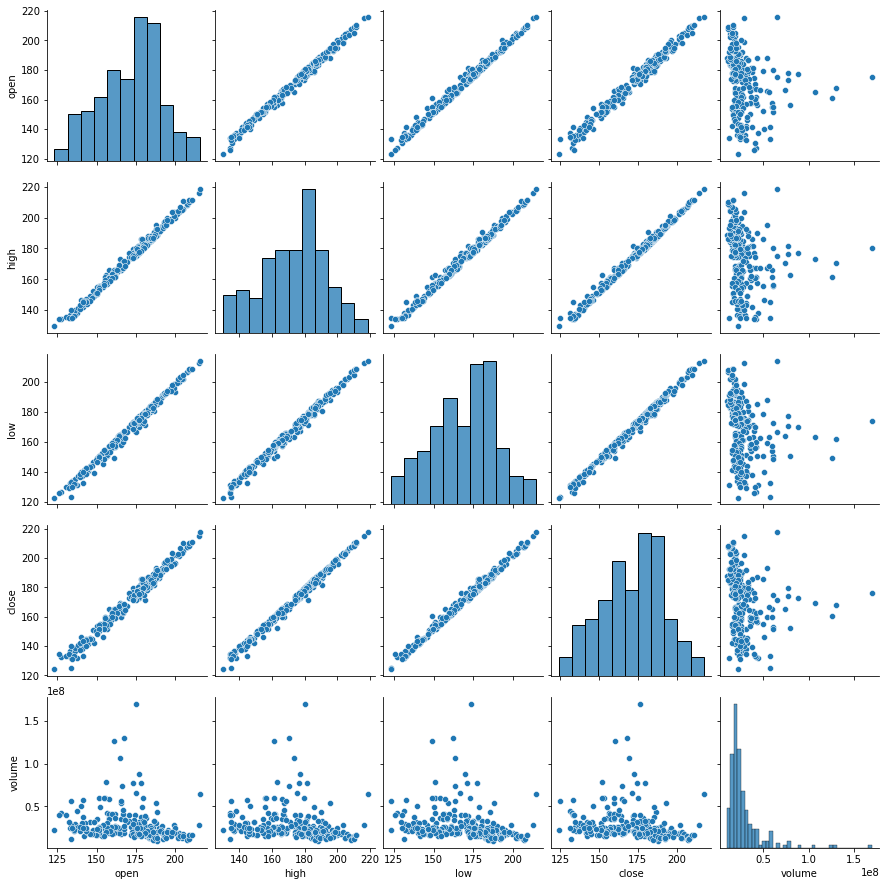

In [8]:
sns.pairplot(fb)

Just as with `pandas` we can specify what to show along the diagonal; however, `seaborn` also allows us to color the data based on another column (or other data with the same shape):

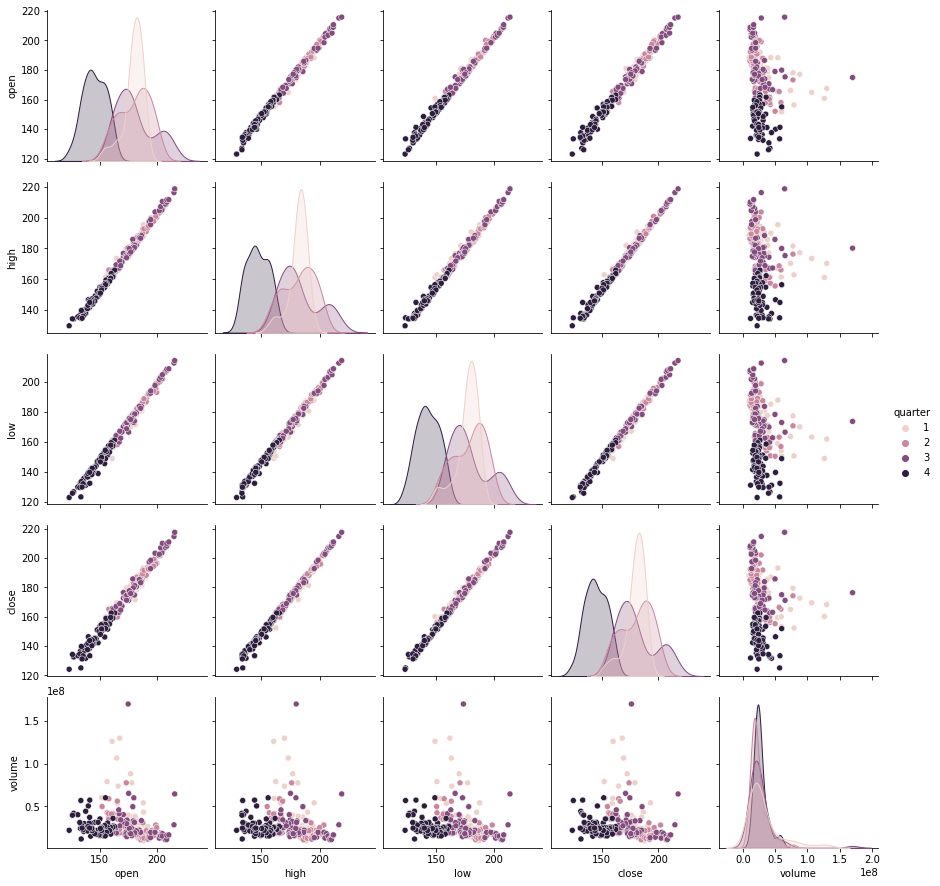

In [9]:
sns.pairplot(
    fb.assign(quarter=lambda x: x.index.quarter),
    diag_kind='kde',
    hue='quarter'
)

### `jointplot()`
The joint plot allows us to visualize the relationship between two variables, like a scatter plot. However, we get the added benefit of being able to visualize their distributions at the same time (as a histogram or KDE). The default options give us a scatter plot in the center and histograms on the sides:

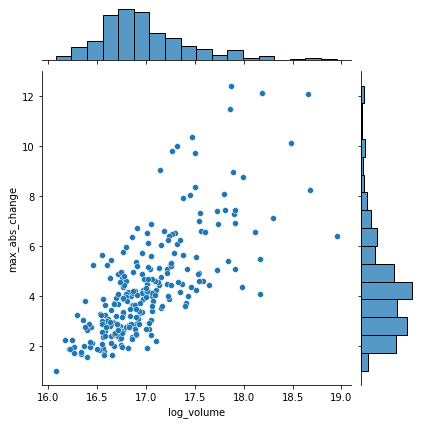

In [10]:
sns.jointplot(
    x='log_volume',
    y='max_abs_change',
    data=fb.assign(
        log_volume=np.log(fb.volume),
        max_abs_change=fb.high - fb.low
    )
)

We can pass `kind='hex'` for hexbins:

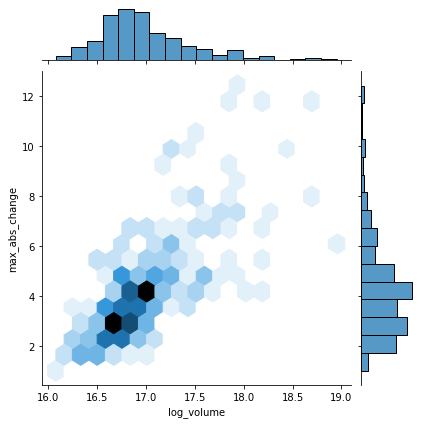

In [11]:
sns.jointplot(
    x='log_volume',
    y='max_abs_change',
    kind='hex',
    data=fb.assign(
        log_volume=np.log(fb.volume),
        max_abs_change=fb.high - fb.low
    )
)

If we pass `kind='kde'`, we get a contour plot of the joint density estimate with KDEs along the sides:

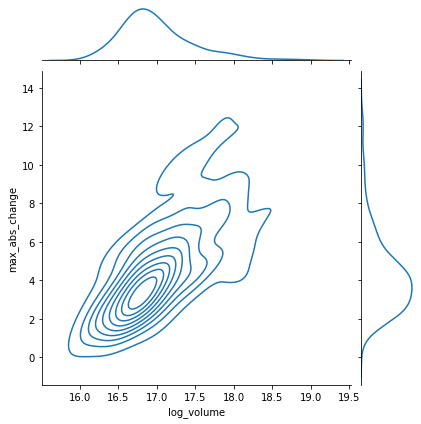

In [12]:
sns.jointplot(
    x='log_volume',
    y='max_abs_change',
    kind='kde',
    data=fb.assign(
        log_volume=np.log(fb.volume),
        max_abs_change=fb.high - fb.low
    )
)

If we specify `kind='reg'` instead, we get a regression line in the center and KDEs on the sides:

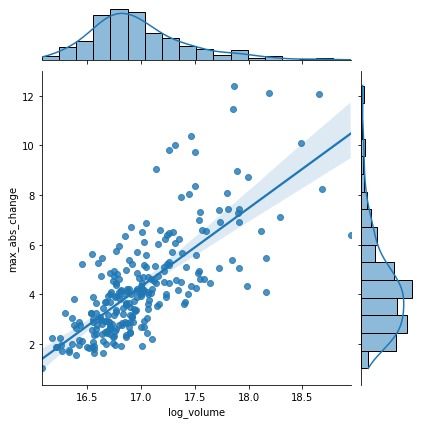

In [13]:
sns.jointplot(
    x='log_volume',
    y='max_abs_change',
    kind='reg',
    data=fb.assign(
        log_volume=np.log(fb.volume),
        max_abs_change=fb.high - fb.low
    )
)

If we pass `kind='resid'`, we get the residuals from the aforementioned regression:

Text(27.125, 0.5, 'residuals')

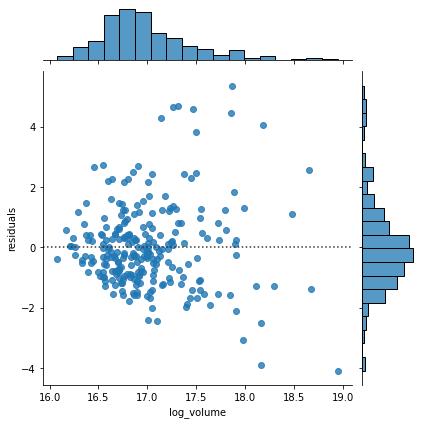

In [14]:
sns.jointplot(
    x='log_volume',
    y='max_abs_change',
    kind='resid',
    data=fb.assign(
        log_volume=np.log(fb.volume),
        max_abs_change=fb.high - fb.low
    )
)
# update y-axis label (discussed in the next notebook)
plt.ylabel('residuals')

## Regression plots
We are going to use `seaborn` to visualize a linear regression between the log of the volume traded in Facebook stock and the maximum absolute daily change (daily high stock price - daily low stock price). To do so, we first need to isolate this data:

In [15]:
fb_reg_data = fb.assign(
    log_volume=np.log(fb.volume),
    max_abs_change=fb.high - fb.low
).iloc[:,-2:]

Since we want to visualize each column as the regressor, we need to look at permutations of their order. Permutations and combinations (among other things) are made easy in Python with `itertools`, so let's import it:

In [16]:
import itertools

`itertools` gives us efficient iterators. Iterators are objects that we loop over, exhausting them. This is an iterator from `itertools`; notice how the second loop doesn't do anything:

In [17]:
iterator = itertools.repeat("I'm an iterator", 1)

for i in iterator:
    print(f'-->{i}')
print('This printed once because the iterator has been exhausted')
for i in iterator:
    print(f'-->{i}')

-->I'm an iterator
This printed once because the iterator has been exhausted


Iterables are objects that can be iterated over. When entering a loop, an iterator is made from the iterable to handle the iteration. Iterators are iterables, but not all iterables are iterators. A list is an iterable. If we turn that iterator into an iterable (a list in this case), the second loop runs:

In [18]:
iterable = list(itertools.repeat("I'm an iterable", 1))

for i in iterable:
    print(f'-->{i}')
print('This prints again because it\'s an iterable:')
for i in iterable:
    print(f'-->{i}')

-->I'm an iterable
This prints again because it's an iterable:
-->I'm an iterable


The `reg_resid_plots()` function from the `viz.py` module in this folder uses `regplot()` and `residplot()` from seaborn along with `itertools` to plot the regression and residuals side-by-side:

In [19]:
from viz import reg_resid_plots
reg_resid_plots??

Signature: reg_resid_plots(data)
Source:   
def reg_resid_plots(data):
    """
    Using `seaborn`, plot the regression and residuals plots
    side-by-side for every permutation of 2 columns in the data.
    
    Parameters:
        - data: A `pandas.DataFrame`

    Returns:
        A matplotlib `Axes` object.
    """
    num_cols = data.shape[1]
    permutation_count = num_cols * (num_cols - 1)

    fig, ax = plt.subplots(permutation_count, 2, figsize=(15, 8))

    for (x, y), axes, color in zip(
        itertools.permutations(data.columns, 2), 
        ax,
        itertools.cycle(['royalblue', 'darkorange'])
    ):
        for subplot, func in zip(axes, (sns.regplot, sns.residplot)):
            func(x=x, y=y, data=data, ax=subplot, color=color)

            if func == sns.residplot:
                # mark the residuals as such
                subplot.set_ylabel('residuals')
    return fig.axes
File:      ~/Hands-On-Data-Analysis-with-Pandas-2nd-edition/ch_06/viz.py
Type:      funct

Let's see what the output looks like for the Facebook data we isolated:

[<AxesSubplot:xlabel='log_volume', ylabel='max_abs_change'>,
 <AxesSubplot:xlabel='log_volume', ylabel='residuals'>,
 <AxesSubplot:xlabel='max_abs_change', ylabel='log_volume'>,
 <AxesSubplot:xlabel='max_abs_change', ylabel='residuals'>]

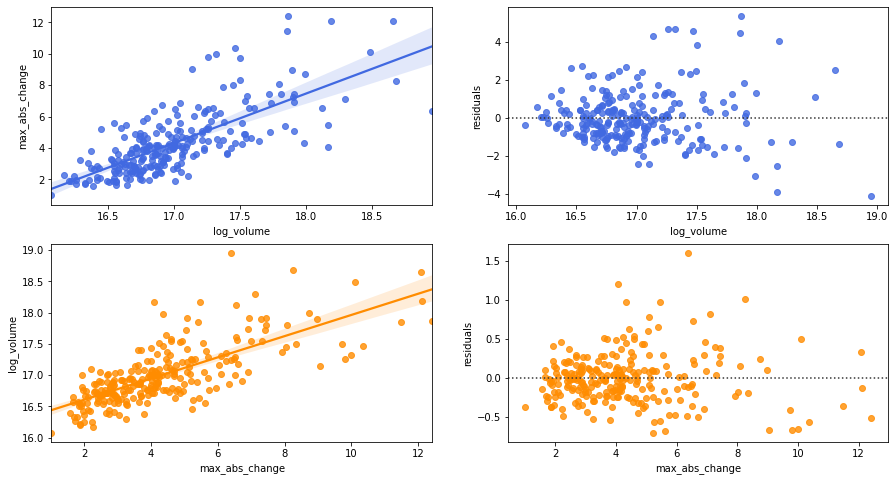

In [20]:
from viz import reg_resid_plots
reg_resid_plots(fb_reg_data)

We can use `lmplot()` to split our regression across subsets of our data. For example, we can perform a regression per quarter on the Facebook stock data:

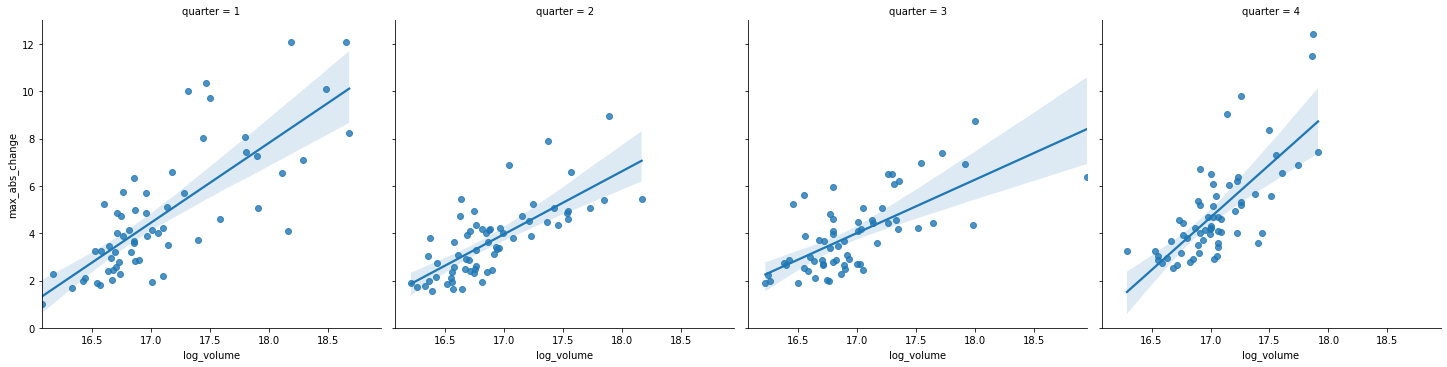

In [21]:
sns.lmplot(
    x='log_volume',
    y='max_abs_change',
    data=fb.assign(
        log_volume=np.log(fb.volume),
        max_abs_change=fb.high - fb.low,
        quarter=lambda x: x.index.quarter
    ),
    col='quarter'
)

## Faceting
We can create subplots across subsets of our data by faceting. First, we create a `FacetGrid` specifying how to lay out the plots (which categorical column goes along the rows and which one along the columns). Then, we call the `map()` method of the `FacetGrid` and pass in the plotting function we want to use (along with any additional arguments).

Let's use a facet grid to show the distribution of earthquake magnitudes in Indonesia and Papua New Guinea by `tsunami` and `parsed_place`:

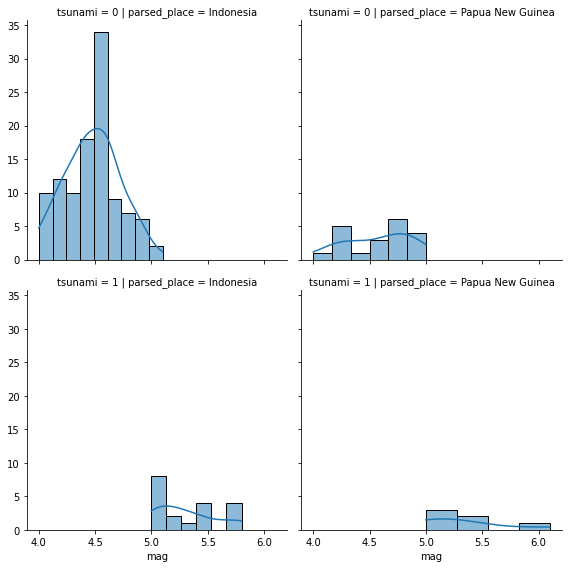

In [22]:
g = sns.FacetGrid(
    quakes.query(
        'parsed_place.isin(["Indonesia", "Papua New Guinea"]) '
        'and magType == "mb"'
    ),
    row='tsunami',
    col='parsed_place',
    height=4
)
g = g.map(sns.histplot, 'mag', kde=True)

<hr>
<div>
    <a href="../ch_05/3-pandas_plotting_module.ipynb">
        <button>&#8592; Chapter 5</button>
    </a>
    <a href="./2-formatting_plots.ipynb">
        <button style="float: right;">Next Notebook &#8594;</button>
    </a>
</div>
<hr>